In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings("ignore")

In [56]:
sepsis_df = pd.read_csv("SyntheticData_Training.csv") 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
sepsis_df.head()

,studyid_adm,agecalc_adm,height_cm_adm,weight_kg_adm,muac_mm_adm,hr_bpm_adm,rr_brpm_app_adm,sysbp_mmhg_adm,diasbp_mmhg_adm,temp_c_adm,...,cookloc_adm,lightfuel_adm,tobacco_adm,bednet_adm,hctpretransfusion_adm,hivstatus_adm,malariastatuspos_adm,lengthadm,caregiver_adm_new,inhospital_mortality
0,1,16.8,79.8,11.6,150.0,130.0,23.0,92.0,54.0,36.3,...,In a separate building/building space used as ...,Electric bulbs (national grid),Never,Always,Yes,HIV negative,No,2,Mother,0
1,2,46.1,93.0,13.6,151.0,115.0,35.0,72.0,42.0,36.8,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,Yes,5,Mother,0
2,3,7.9,68.2,8.2,148.0,150.0,56.0,94.0,51.0,37.2,...,In a separate building/building space used as ...,Tadooba,Never,Always,Yes,HIV negative,No,4,Mother,0
3,4,38.2,95.0,12.0,138.0,134.0,38.0,94.0,57.0,37.6,...,In the house where you sleep,Electric bulbs (national grid),Never,Always,NaN,HIV negative,Yes,5,Mother,0
4,5,16.1,83.0,12.0,165.0,163.0,61.0,107.0,73.0,38.7,...,Outdoors in the open,Electric bulbs (national grid),Never,Sometimes,Yes,HIV negative,Yes,7,Mother,0


In [58]:
sepsis_df.info()
pd.set_option('display.max_rows', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Columns: 138 entries, studyid_adm to inhospital_mortality
dtypes: float64(23), int64(3), object(112)
memory usage: 2.8+ MB


In [60]:
sepsis_df.duplicated().sum()

0

In [62]:
#Create a summary DataFrame of column characteristics

column_summary= pd.DataFrame({'Column': sepsis_df.columns, 
                              'Data Type': sepsis_df.dtypes.values,
                              'Missing Values': sepsis_df.isnull().sum().values,
                              'Missing %': (sepsis_df.isnull().mean() * 100).values,
                              'Unique Values': sepsis_df.nunique().values})



# Display all rows in the column summary
pd.set_option('display.max_rows', None)

# Print
print(column_summary)

                       Column Data Type  Missing Values  Missing %  \
0                 studyid_adm     int64               0   0.000000   
1                 agecalc_adm   float64               0   0.000000   
2               height_cm_adm   float64              14   0.521221   
3               weight_kg_adm   float64               9   0.335071   
4                 muac_mm_adm   float64              13   0.483991   
5                  hr_bpm_adm   float64               1   0.037230   
6             rr_brpm_app_adm   float64               5   0.186150   
7              sysbp_mmhg_adm   float64               2   0.074460   
8             diasbp_mmhg_adm   float64               1   0.037230   
9                  temp_c_adm   float64               1   0.037230   
10       spo2site1_pc_oxi_adm   float64               4   0.148920   
11       spo2site2_pc_oxi_adm   float64             205   7.632167   
12              spo2other_adm   float64            2505  93.261355   
13                 m

___
Dropped intervention columns: These variables represent treatments that, while powerful predictors, are excluded due to their post-admission nature. The model, however, relies on data available at the time of admission.
___

In [64]:
# Removing leading/trailing whitespace
sepsis_df.columns = sepsis_df.columns.str.strip()

# Define the intervention columns we want to drop
intervention_cols = [f"admitabx_adm___{i}" for i in range(1, 22)]

# Dropping them
sepsis_df.drop(columns=intervention_cols, inplace=True, errors='ignore')

# Confirming
print("Remaining columns:", sepsis_df.shape[1])
print("Dropped intervention columns:", intervention_cols)


Remaining columns: 117
Dropped intervention columns: ['admitabx_adm___1', 'admitabx_adm___2', 'admitabx_adm___3', 'admitabx_adm___4', 'admitabx_adm___5', 'admitabx_adm___6', 'admitabx_adm___7', 'admitabx_adm___8', 'admitabx_adm___9', 'admitabx_adm___10', 'admitabx_adm___11', 'admitabx_adm___12', 'admitabx_adm___13', 'admitabx_adm___14', 'admitabx_adm___15', 'admitabx_adm___16', 'admitabx_adm___17', 'admitabx_adm___18', 'admitabx_adm___19', 'admitabx_adm___20', 'admitabx_adm___21']


In [66]:
# Dropping unnecessary columns
sepsis_df = sepsis_df.drop(["spo2other_adm","lactate2_mmolpl_adm","nonexclbreastfed_adm","vaccmeaslessource_adm"], axis=1)


*Clean numeric-columns*

In [88]:
# Step 1: Get columns that have at least one missing value
cols_with_missing = sepsis_df.columns[sepsis_df.isnull().any()].tolist()

# Step 2: Create a new DataFrame with only those columns
df_missing_subset = sepsis_df[cols_with_missing]

In [91]:
# Step 1: Select numeric columns only
numeric_cols = df_missing_subset.select_dtypes(include='number')

# Step 2: Calculate skewness for each numeric column
skewness = numeric_cols.skew()

# Step 3: Filter columns where skewness is between -0.5 and +0.5
symmetric_cols = skewness[(skewness > -0.5) & (skewness < 0.5)].index.tolist()

print("Columns with fairly symmetric distributions:", symmetric_cols)

Columns with fairly symmetric distributions: ['muac_mm_adm', 'sysbp_mmhg_adm', 'diasbp_mmhg_adm', 'shockindex_heart_rate_sbp_adm']


___
Columns with fairly symmetric distributions (skewness between -0.5 and 0.5) were identified using the `.skew()` function and separated for imputation using the **mean**. For columns with more skewed distributions (skewness < -0.5 or > 0.5), the **median** will be used instead, as it's more robust to outliers.
___

In [94]:
# Step 1: Define the age group bins
def assign_age_group(age_months):
    if age_months < 6:
        return '3-6 month'
    elif age_months < 12:
        return '6-1yr'
    elif age_months < 24:
        return '1-2yr'
    elif age_months < 36:
        return '2-3yr'
    elif age_months < 48:
        return '3-4yr'
    elif age_months < 60:
        return '4-5yr'
    elif age_months < 72:
        return '5-6yr'
    else:
        return 'older'

# Step 2: Create 'age_group' column
sepsis_df['age_group'] = sepsis_df['agecalc_adm'].apply(assign_age_group)

# Step 3: Group by age_group and sex_adm, then impute hematocrit
sepsis_df['hematocrit_gpdl_adm'] = sepsis_df.groupby(['age_group', 'sex_adm'])['hematocrit_gpdl_adm']\
    .transform(lambda x: x.fillna(x.mean()))
print(sepsis_df["hematocrit_gpdl_adm"].isnull().sum())

0


___
" hematocrit_gpdl_adm " was imputed using a logical, group-based approach. Since hematocrit levels vary by age and sex, first  patients were categorized into age groups and then grouped the data by both age_group and sex_adm.
Within each group, missing hematocrit values were filled using the mean of that group, ensuring the imputation respects biologically relevant differences.
___

In [99]:
sepsis_df["hr_bpm_adm"]=sepsis_df["hr_bpm_adm"].fillna(sepsis_df["hr_bpm_adm"].median())
sepsis_df["hr_bpm_adm"].isnull().sum()

0

___
"hr_bpm_adm" was imputed using median since found to be assymetric.
___

In [104]:
sepsis_df["sysbp_mmhg_adm"]=sepsis_df["sysbp_mmhg_adm"].fillna(sepsis_df["sysbp_mmhg_adm"].mean())
sepsis_df["sysbp_mmhg_adm"].isnull().sum()

0

___
"sysbp_mmhg_adm" was imputed using mean since found to be fairly symetric.
___

In [109]:
# Create shock index column
sepsis_df['shockindex_heart_rate_sbp_adm'] = sepsis_df['hr_bpm_adm'] / sepsis_df['sysbp_mmhg_adm']
print(sepsis_df["shockindex_heart_rate_sbp_adm"].isnull().sum())

0


___
"shockindex_heart_rate_sbp_adm" was created to aid imputation of missing values in the "lactate_mmolpl_adm" column. It was derived from "hr_bpm_adm" and "sysbp_mmhg_adm"  columns. 
___

In [114]:
# Create high-risk indicator based on SpO2 and shock index
sepsis_df['high_risk'] = ((sepsis_df['spo2site1_pc_oxi_adm'] < 90) | 
                          (sepsis_df['shockindex_heart_rate_sbp_adm'] > 1)).astype(int)

# Impute lactate using median within risk groups (only one transform needed)
sepsis_df['lactate_mmolpl_adm'] = sepsis_df.groupby('high_risk')['lactate_mmolpl_adm']\
                                           .transform(lambda x: x.fillna(x.median()))
print(sepsis_df["lactate_mmolpl_adm"].isnull().sum())

0


___
* Created a `high_risk` flag for patients with SpO₂ < 90 or shock index > 1.
  These thresholds are clinically meaningful indicators of potential instability.
* Imputed missing `lactate_mmolpl_adm` values using the median within each risk group.
  This ensures imputation is done in a context-sensitive way, preserving group-level distribution patterns.
  
___
m

In [119]:
# Use spo2site2 to fill missing values in spo2site1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df['spo2site1_pc_oxi_adm'].fillna(
    sepsis_df['spo2site2_pc_oxi_adm']
)
# Use spo2site1 to fill missing values in spo2site2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df['spo2site2_pc_oxi_adm'].fillna(
    sepsis_df['spo2site1_pc_oxi_adm']
)
print(sepsis_df['spo2site1_pc_oxi_adm'].isnull().sum())
print(sepsis_df['spo2site2_pc_oxi_adm'].isnull().sum())


0
0


In [121]:
# Create age group
sepsis_df['age_group2'] = sepsis_df['agecalc_adm'].apply(lambda x: '<1yr' if x < 1 else '≥1yr')

# Impute SpO2 site 1
sepsis_df['spo2site1_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site1_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))

# Impute SpO2 site 2
sepsis_df['spo2site2_pc_oxi_adm'] = sepsis_df.groupby('age_group2')['spo2site2_pc_oxi_adm']\
                                             .transform(lambda x: x.fillna(x.median()))
print(sepsis_df['spo2site1_pc_oxi_adm'].isnull().sum())
print(sepsis_df['spo2site2_pc_oxi_adm'].isnull().sum())

0
0


___
The columns **'spo2site1\_pc\_oxi\_adm'** and **'spo2site2\_pc\_oxi\_adm'** represent oxygen saturation levels (percentage of hemoglobin carrying oxygen) from two different body sites. Since both measure similar values, **cross imputation** was used to fill missing values. However, 4 missing values were observed, suggesting that 4 rows were missing data for both columns. To account for age-related physiological differences (e.g., respiratory rate, oxygen saturation, heart rate), an **age\_group2** variable was created to categorize patients as <1 year or ≥1 year. Missing SpO₂ values were then imputed using the median within each age group.
___

In [126]:
# Use sqi2 to fill missing values in sqi1
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(
    sepsis_df['sqi2_perc_oxi_adm']
)

# Use sqi1 to fill missing values in sqi2
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(
    sepsis_df['sqi1_perc_oxi_adm']
)
print(sepsis_df['sqi1_perc_oxi_adm'].isnull().sum())
print(sepsis_df['sqi2_perc_oxi_adm'].isnull().sum())

0
0


In [128]:
sepsis_df['sqi1_perc_oxi_adm'] = sepsis_df['sqi1_perc_oxi_adm'].fillna(sepsis_df['sqi1_perc_oxi_adm'].median())
sepsis_df['sqi2_perc_oxi_adm'] = sepsis_df['sqi2_perc_oxi_adm'].fillna(sepsis_df['sqi2_perc_oxi_adm'].median())
print(sepsis_df['sqi1_perc_oxi_adm'].isnull().sum())
print(sepsis_df['sqi2_perc_oxi_adm'].isnull().sum())

0
0


___
The columns **'sqi1\_perc\_oxi\_adm'** and **'sqi2\_perc\_oxi\_adm'** represent the best and second-best SpO₂ signal quality index at admission. 
* **`sqi1_perc_oxi_adm`** = Highest quality SpO₂ signal among all measured sites at admission.
* **`sqi2_perc_oxi_adm`** = Second-best quality SpO₂ signal from a different site at admission.
Since they are related, **cross-imputation** was applied. However, 126 rows remained missing for both columns, so the remaining missing values were filled using the median.
___

#### height_cm_adm

In [132]:
# Show relevant info where height is missing
sepsis_df.loc[sepsis_df['height_cm_adm'].isnull(), ['weight_kg_adm', 'agecalc_adm', 'sex_adm']]

,weight_kg_adm,agecalc_adm,sex_adm
370,13.0,23.3,Male
430,NaN,29.0,Male
858,NaN,30.1,Female
928,NaN,26.9,Male
956,5.8,22.0,Male
1025,NaN,15.5,Male
1178,13.0,52.2,Female
1360,NaN,21.2,Female
1785,9.0,22.5,Male
1855,9.0,10.6,Male


* To handle missing values in the height_cm_adm column, the approach involves imputing the missing heights using the WHO median height-for-age data. The patient's age in months is rounded to the nearest whole number to align with the WHO data, which includes median height values for different age months. The missing values in the height_cm_adm column are then filled with the corresponding median height from the WHO dataset based on the patient's rounded age.
  
* This method ensures that the imputed heights are age-appropriate and based on established growth standards, improving the overall quality of the dataset for analysis.

##### *For Female*

In [134]:
# Loading the WHO dataset for girls
who_girls = pd.read_csv("girls_length_height_for_age.csv")

In [136]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean = who_girls[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean,
    on='age_months_rounded',
    how='left'
)

* The patient's age in months is rounded to the nearest whole number to align with the WHO data. The WHO median height-for-age data for girls is then cleaned and merged with the sepsis dataset based on the rounded age.

* This ensures that each patient is matched with the appropriate WHO median height based on their age.

In [138]:
# Identify missing heights for female patients
girls_mask = (sepsis_df['sex_adm'] == 'Female') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age
sepsis_df.loc[girls_mask, 'height_cm_adm'] = sepsis_df.loc[girls_mask, 'who_median_height']

* This code identifies missing height values for female patients by creating a mask where the sex_adm is 'Female' and height_cm_adm is null.

* Then, for these patients, the missing height values are imputed using the corresponding WHO median height based on the patient's rounded age in months.

##### *For Male*

In [140]:
# Loading the WHO dataset for boys
who_boys = pd.read_csv("boys_length_height_for_age.csv")

In [142]:
# Round age to match WHO months
sepsis_df['age_months_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Prepare WHO data
who_clean_boys = who_boys[['Months', 'Median']].rename(columns={
    'Months': 'age_months_rounded',
    'Median': 'who_median_height_boys'
})

# Merge on the rounded age
sepsis_df = sepsis_df.merge(
    who_clean_boys,
    on='age_months_rounded',
    how='left'
)

* In this process, the age calculation of the children in the sepsis dataset is rounded to the nearest whole month using the agecalc_adm column. This rounded age is stored in a new column age_months_rounded.

* Next, the WHO data for boys is prepared by extracting the relevant columns (Months and Median) from the who_boys dataset and renaming them to age_months_rounded and who_median_height_boys, ensuring consistency with the sepsis dataset.

* Finally, the two datasets are merged based on the rounded age (age_months_rounded), allowing the sepsis dataset to be enriched with the WHO median height for boys based on the rounded age, creating a column called who_median_height_boys in the sepsis_df.

In [146]:
# Identify missing heights for male patients
boys_mask = (sepsis_df['sex_adm'] == 'Male') & (sepsis_df['height_cm_adm'].isna())

# Impute with WHO median height based on rounded age for boys
sepsis_df.loc[boys_mask, 'height_cm_adm'] = sepsis_df.loc[boys_mask, 'who_median_height_boys']

# Check for missing values again
sepsis_df['height_cm_adm'].isna().sum()

0

* This process identifies missing height values (height_cm_adm) for male patients in the dataset.
* For those missing values, the heights are imputed using the WHO median height for boys based on the rounded age.
* After the imputation, the number of remaining missing height values is checked to confirm the success of the imputation of the **height_cm_adm** column.

#### weight_kg_adm

* To impute missing weight values in the dataset, we used a reference-based approach leveraging the WHO weight-for-age data. By rounding the age of each patient to the nearest integer, we matched it with the corresponding median weight for boys and girls from the WHO dataset. This allowed us to impute missing weights based on the median value for the given age and sex, ensuring a more accurate and contextually relevant imputation method.

In [137]:
# Load WHO data
boys_wfa = pd.read_csv("boys_weight_for_age.csv")  
girls_wfa = pd.read_csv("girls_weight_for_age.csv") 

In [139]:
# Round the age to the nearest integer
sepsis_df['agecalc_adm_rounded'] = sepsis_df['agecalc_adm'].round().astype(int)

# Function to impute missing weight values
def impute_weight(row):
    if pd.isna(row['weight_kg_adm']):
        if row['sex_adm'] == 'Male':
            # Get the median weight for boys based on the agecalc_adm
            ref = boys_wfa[boys_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        else:
            # Get the median weight for girls based on the agecalc_adm
            ref = girls_wfa[girls_wfa['Months'] == row['agecalc_adm_rounded']]['Median'].values[0]
        return ref
    return row['weight_kg_adm']

# Apply the imputation to the dataset
sepsis_df['weight_kg_adm'] = sepsis_df.apply(impute_weight, axis=1)

# Check for missing values again
sepsis_df['weight_kg_adm'].isna().sum()

0

* The process of imputing missing values in the weight_kg_adm column begins by loading the WHO weight-for-age datasets for boys and girls. The age column (agecalc_adm) in the sepsis_df dataset is then rounded to the nearest integer to match the age format used in the WHO datasets. A custom function, impute_weight, is created to fill in missing values.
* For each row with a missing weight, the function checks the sex of the patient and retrieves the corresponding median weight from the appropriate WHO dataset (boys or girls) based on the rounded age. This median value is then used to impute the missing weight.
* The function is applied to the entire dataset, and the weight_kg_adm column is updated accordingly. Finally, a check is performed to confirm that there are no remaining missing values in the weight column, ensuring successful imputation.

#### muac_mm_adm

In [141]:
# Suppress all warning messages to keep output clean
warnings.filterwarnings("ignore")

# Divide 'weight_kg_adm' into 5 equal-sized bins (quintiles) and assign to 'weight_group'
sepsis_df['weight_group'] = pd.qcut(sepsis_df['weight_kg_adm'], 5)

# Group by 'age_group', 'weight_group', and 'sex_adm', then fill missing 'muac_mm_adm' values with the group mean
sepsis_df['muac_mm_adm'] = sepsis_df.groupby(
    ['age_group', 'weight_group', 'sex_adm']
)['muac_mm_adm'].transform(lambda x: x.fillna(x.mean()))

# Print how many missing values remain in 'muac_mm_adm']\
print(sepsis_df["muac_mm_adm"].isnull().sum())

0


* The above code imputes missing values in the Mid-Upper Arm Circumference (MUAC) column based on weight-for-age groups.

* First, it divides the dataset into five quantiles based on the weight of the patients using the pd.qcut() function. Each quantile represents a group of patients with similar weights. Then, for each group, the code uses the groupby() function to group the data and applies a transformation to the MUAC column.

* It fills the missing values in the MUAC column with the median value of the corresponding group. This approach assumes that children with similar weights are likely to have similar MUAC measurements, so the median value within each weight group is used to impute the missing data. The median is chosen because it is more robust to outliers compared to the mean, making it a suitable choice for imputation in this case.

#### bcseye_adm

* This below code investigates whether missing values in the bcseye_adm variable (Blantyre Coma Scale – Eye Response) are associated with the availability of related coma scale components, specifically:
                        
                        - bcsmotor_adm – Motor Response
                        - bcsverbal_adm – Verbal Response

In [143]:
# Identify rows where 'bcseye_adm' is missing
missing_eye = sepsis_df['bcseye_adm'].isna()

# Print the corresponding 'bcsmotor_adm' and 'bcsverbal_adm' values where 'bcseye_adm' is missing
print(sepsis_df[missing_eye][['bcsmotor_adm', 'bcsverbal_adm']])

Empty DataFrame
Columns: [bcsmotor_adm, bcsverbal_adm]
Index: []


In [145]:
# Verifying the exact patient record
patient_1388 = sepsis_df.loc[1388, ['bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm']]
print(patient_1388)

bcseye_adm                                Fails to watch or follow
bcsmotor_adm                 No response or inappropriate response
bcsverbal_adm    Cries appropriately with pain, or, if verbal, ...
Name: 1388, dtype: object


In [151]:
# Impute missing as "NoFollow" (most severe neurological status)
sepsis_df['bcseye_adm'] = sepsis_df['bcseye_adm'].fillna('Fails to watch or follow')
print(sepsis_df["bcseye_adm"].isnull().sum())


0


* This output shows that even though bcseye_adm is missing for this patient (row 1388):
                        
                        - bcsmotor_adm is present but indicates very low motor responsiveness
                        - bcsverbal_adm is present and shows some verbal responsiveness

**Since bcsmotor_adm is very low and bcseye_adm is missing, it is reasonable to impute a worst-case value like "Fails to watch or follow" for bcseye_adm**

#### bcsverbal_adm

In [62]:
# Identify rows where 'bcsverbal_adm' (verbal response) is missing
missing_verbal = sepsis_df['bcsverbal_adm'].isna()

# Display corresponding eye and motor responses for those rows
print(sepsis_df[missing_verbal][['bcseye_adm', 'bcsmotor_adm']])

              bcseye_adm                          bcsmotor_adm
507   Watches or follows  Withdraws limb from painful stimulus
1205  Watches or follows  Withdraws limb from painful stimulus


* This code identifies all records where the verbal response (bcsverbal_adm) is missing and displays the corresponding eye and motor response values. It helps assess whether there is a consistent pattern that could be used to logically impute the missing verbal scores.

In [78]:
# Filter records with the same eye/motor scores to find the most frequent verbal response
subgroup_mask = (
    (sepsis_df['bcseye_adm'] == 'Watches or follows') & 
    (sepsis_df['bcsmotor_adm'] == 'Withdraws limb from painful stimulus')
)
mode_verbal = sepsis_df[subgroup_mask]['bcsverbal_adm'].mode()[0]  # Most common in this subgroup

# Apply to missing cases
sepsis_df.loc[[507, 1205], 'bcsverbal_adm'] = mode_verbal

* This code filters the dataset to records where both the eye and motor responses match the specified clinical patterns. It then identifies the most common (modal) verbal response within that subgroup. This modal value is then used to fill in the missing verbal response entries (rows 507 and 1205), ensuring the imputation is clinically consistent.

In [155]:
sepsis_df["diasbp_mmhg_adm"] = sepsis_df["diasbp_mmhg_adm"].fillna(sepsis_df["diasbp_mmhg_adm"].mean())
print(sepsis_df["diasbp_mmhg_adm"].isnull().sum())

0


___
The missing values in the diasbp_mmhg_adm column were imputed with the mean of the existing values since found to be fairly symmetric.
___

In [160]:
# Step 1: Get columns that have at least one missing value
cols_with_missing2 = sepsis_df.columns[sepsis_df.isnull().any()].tolist()

# Step 2: Create a new DataFrame with only those columns
df_missing_subset2 = sepsis_df[cols_with_missing2]

# Step 3: Select numeric columns only
numeric_cols2 = df_missing_subset2.select_dtypes(include='number').columns

# Step 4: Fill missing values in numeric columns with the median of each column
df_missing_subset2[numeric_cols2] = df_missing_subset2[numeric_cols2].fillna(df_missing_subset2[numeric_cols2].median())
# Update the original Sepsis_df with the imputed numeric columns
sepsis_df[numeric_cols2] = df_missing_subset2[numeric_cols2]



___
The remaining numeric columns with null values were imputed using the median, as the number of missing values was relatively small and found to be asymmetrically distributed. This approach ensures that the imputed values do not skew the data significantly.
___

___
The remaining numeric columns with null values were imputed using the median, as the number of missing values was relatively small and found to be asymmetrically distributed. This approach ensures that the imputed values do not skew the data significantly.
___

In [168]:
sepsis_df['hivstatus_adm'] = sepsis_df['hivstatus_adm'].fillna('NotTested')
print(sepsis_df["hivstatus_adm"].isnull().sum())

0


___
The column **'hivstatus\_adm'** was imputed with **'NotTested'** since it was challenging to reliably estimate the missing values using the same or related columns.
___

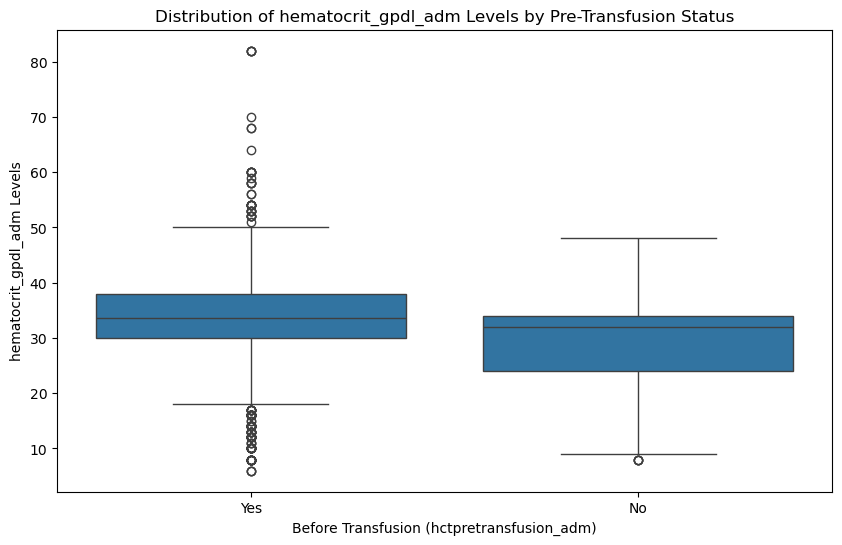

In [173]:
# Step 1: Plot 'hematocrit_gpdl_adm' levels before and after transfusion using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='hctpretransfusion_adm', 
    y='hematocrit_gpdl_adm',  # Replace ''hematocrit_gpdl_adm'' with the actual column name for HCT values
    data=sepsis_df
)
plt.title('Distribution of hematocrit_gpdl_adm Levels by Pre-Transfusion Status')
plt.xlabel('Before Transfusion (hctpretransfusion_adm)')
plt.ylabel('hematocrit_gpdl_adm Levels')
plt.show()


In [175]:
# First, calculate mode (most frequent value)
mode_value = sepsis_df['hctpretransfusion_adm'].mode()[0]

# Define custom function
def impute_hctpretransfusion(row):
    if pd.isna(row['hctpretransfusion_adm']):
        if row['hematocrit_gpdl_adm'] < 10 or row['hematocrit_gpdl_adm'] > 50:
            return 'Yes'
        else:
            return mode_value
    else:
        return row['hctpretransfusion_adm']

# Apply the function to fill missing values
sepsis_df['hctpretransfusion_adm'] = sepsis_df.apply(impute_hctpretransfusion, axis=1)
print(sepsis_df['hctpretransfusion_adm'].isnull().sum())


0


___
**"hctpretransfusion\_adm"** was imputed using a **distribution-based method** guided by a box plot analysis. Since the upper whisker for “No” responses was around 50 and the lower whisker around 10 (based on hematocrit values), missing entries with hematocrit values outside this range were classified as **"Yes"**. The remaining missing values were filled using the **mode**.
___


In [182]:
# Step 1: Select non-numeric columns with missing values
non_numeric_missing = sepsis_df.select_dtypes(exclude='number').columns
non_numeric_missing = [col for col in non_numeric_missing if sepsis_df[col].isnull().any()]

# Step 2: Fill each with its own mode
for col in non_numeric_missing:
    mode_val = sepsis_df[col].mode()[0]
    sepsis_df[col] = sepsis_df[col].fillna(mode_val)

___
non numeric columns other than **'hivstatus\_adm'** and **"hctpretransfusion_adm"** were filled using mode
___

In [187]:
# Configure pandas to display details for up to 150 columns in the .info() summary
#  By default, pandas displays a maximum of 100 columns in .info()
# If the DataFrame has more than 100 columns, the output is truncated.
pd.set_option('display.max_info_columns', 150)
sepsis_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 119 columns):
 #    Column                         Non-Null Count  Dtype   
---   ------                         --------------  -----   
 0    studyid_adm                    2686 non-null   int64   
 1    agecalc_adm                    2686 non-null   float64 
 2    height_cm_adm                  2686 non-null   float64 
 3    weight_kg_adm                  2686 non-null   float64 
 4    muac_mm_adm                    2686 non-null   float64 
 5    hr_bpm_adm                     2686 non-null   float64 
 6    rr_brpm_app_adm                2686 non-null   float64 
 7    sysbp_mmhg_adm                 2686 non-null   float64 
 8    diasbp_mmhg_adm                2686 non-null   float64 
 9    temp_c_adm                     2686 non-null   float64 
 10   spo2site1_pc_oxi_adm           2686 non-null   float64 
 11   spo2site2_pc_oxi_adm           2686 non-null   float64 
 12   momage_adm        

In [193]:
sepsis_df.columns.get_loc('inhospital_mortality')
sepsis_df = sepsis_df.drop(sepsis_df.columns[113:],axis=1)
sepsis_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 113 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    studyid_adm               2686 non-null   int64  
 1    agecalc_adm               2686 non-null   float64
 2    height_cm_adm             2686 non-null   float64
 3    weight_kg_adm             2686 non-null   float64
 4    muac_mm_adm               2686 non-null   float64
 5    hr_bpm_adm                2686 non-null   float64
 6    rr_brpm_app_adm           2686 non-null   float64
 7    sysbp_mmhg_adm            2686 non-null   float64
 8    diasbp_mmhg_adm           2686 non-null   float64
 9    temp_c_adm                2686 non-null   float64
 10   spo2site1_pc_oxi_adm      2686 non-null   float64
 11   spo2site2_pc_oxi_adm      2686 non-null   float64
 12   momage_adm                2686 non-null   float64
 13   momagefirstpreg_adm       2686 non-null   floa

___
                                                Observation : *** All columns do not contain missing value. ***
___

In [198]:
from scipy import stats

from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

# 1. Separate categorical and continuous features
target = 'inhospital_mortality'
categorical_features = sepsis_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
continuous_features = sepsis_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target]).columns.tolist()

# 2. Chi-Square test for categorical features
significant_cat = []
for col in categorical_features:
    contingency = pd.crosstab(sepsis_df[col], sepsis_df[target])
    if contingency.shape[0] > 1:
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        if p < 0.01:
            significant_cat.append(col)

# 3. Mann-Whitney U Test for continuous features
significant_cont = []
for col in continuous_features:
    group0 = sepsis_df[sepsis_df[target] == 0][col]
    group1 = sepsis_df[sepsis_df[target] == 1][col]
    try:
        u_stat, p_value = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        if p_value < 0.01:
            significant_cont.append(col)
    except:
        pass  # Skip if error due to too many NaNs or invalid inputs

# 4. Combine and review
significant_features = significant_cat + significant_cont
print(f"Total insignificant features (p < 0.01): {len(significant_features)}")
print(significant_features)

Total insignificant features (p < 0.01): 19
['spo2onoxy_adm', 'oxygenavail_adm', 'respdistress_adm', 'caprefill_adm', 'bcseye_adm', 'bcsmotor_adm', 'bcsverbal_adm', 'bcgscar_adm', 'symptoms_adm___14', 'symptoms_adm___15', 'diarrheaoften_adm', 'feedingstatus_adm', 'totalbreastfed_adm', 'caregivermarried_adm', 'waterpure_adm', 'bednet_adm', 'hctpretransfusion_adm', 'weight_kg_adm', 'lactate_mmolpl_adm']


In [202]:
import pandas as pd

# Identify categorical columns
categorical_cols = sepsis_df.select_dtypes(include='object').columns

# Count unique values in each categorical column
cat_unique_counts = sepsis_df[categorical_cols].nunique().sort_values()

# Create a summary DataFrame
cat_summary = pd.DataFrame({
    'Categorical Variable': cat_unique_counts.index,
    'Unique Values Count': cat_unique_counts.values
})

# Display all rows
pd.set_option('display.max_rows', None)

# Print the full summary
print(cat_summary)


        Categorical Variable  Unique Values Count
0          symptoms_adm___18                    1
1        comorbidity_adm___4                    1
2        comorbidity_adm___2                    2
3        comorbidity_adm___3                    2
4        comorbidity_adm___5                    2
5        comorbidity_adm___6                    2
6        comorbidity_adm___7                    2
7        comorbidity_adm___8                    2
8        comorbidity_adm___9                    2
9       comorbidity_adm___10                    2
10      comorbidity_adm___11                    2
11      malariastatuspos_adm                    2
12          duedateknown_adm                    2
13       birthdetail_adm___1                    2
14       birthdetail_adm___2                    2
15       comorbidity_adm___1                    2
16                   sex_adm                    2
17       birthdetail_adm___5                    2
18       birthdetail_adm___6                    2


In [204]:
# Display a few example values from each categorical column
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(sepsis_df[col].dropna().unique()[:5])  # Show up to 5 unique non-null values



Column: sex_adm
['Female' 'Male']

Column: spo2onoxy_adm
['No' 'Yes']

Column: oxygenavail_adm
['Oxygen available and not being used' 'Oxygen available and being used'
 'Oxygen not available' 'Oxygen available but not enough']

Column: respdistress_adm
['No' 'Yes']

Column: caprefill_adm
['No' 'Yes']

Column: bcseye_adm
['Watches or follows' 'Fails to watch or follow']

Column: bcsmotor_adm
['Localizes painful stimulus' 'Withdraws limb from painful stimulus'
 'No response or inappropriate response']

Column: bcsverbal_adm
['Cries appropriately with pain, or, if verbal, speaks'
 'Moan or abnormal cry with pain' 'No vocal response to pain']

Column: bcgscar_adm
['Yes' 'No']

Column: vaccmeasles_adm
['Yes' 'No' 'Unknown']

Column: vaccpneumoc_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccpneumocsource_adm
['Self report' 'Card']

Column: vaccdpt_adm
['3 doses' '2 doses' 'Unknown' '0 doses' '1 dose']

Column: vaccdptsource_adm
['Self report' 'Card']

Column: priorweek